In [1]:
from shapely.geometry import MultiLineString, LineString
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
def rnet_subset(rnet_x, rnet_y, dist=0.0002, crop=True, min_length=0, rm_disconnected=True):
    rnet_x['length_x_original'] = rnet_x.geometry.length
    rnet_y_union = unary_union(rnet_y.geometry)
    rnet_y_buffer = rnet_y_union.buffer(dist, cap_style=2)
    rnet_y_buffer_geo_df = gpd.GeoDataFrame(geometry=[rnet_y_buffer], crs=rnet_y.crs)

    if crop:
        overlay_result = gpd.overlay(rnet_x, rnet_y_buffer_geo_df, how='intersection')
        rnet_x = gpd.GeoDataFrame(overlay_result, geometry='geometry')
        rnet_x['geometry'] = rnet_x.geometry.apply(line_cast) # Cast lines
        rnet_x = rnet_x.explode('geometry')
    else:
        rnet_x = rnet_x[rnet_x.geometry.within(rnet_y_buffer)] # Filter using within
    # Convert rnet_x back to a GeoDataFrame
    rnet_x = gpd.GeoDataFrame(rnet_x, geometry='geometry')

    if min_length > 0:
        rnet_x = rnet_x[rnet_x.geometry.length > min_length] # Filter by length

    # Ensure that the geometry column contains only LineString objects
    rnet_x['geometry'] = rnet_x['geometry'].apply(lambda geom: geom if isinstance(geom, LineString) else None)
    rnet_x.dropna(subset=['geometry'], inplace=True)

    if rm_disconnected:
        rnet_x = rnet_connected(rnet_x) # Remove disconnected components

    return rnet_x


def line_cast(geometry):
    if isinstance(geometry, MultiLineString):
        return [LineString(line) for line in geometry.geoms]
    else:
        return geometry

def rnet_connected(rnet):
    G = nx.Graph()

    # Add edges to the graph based on spatial relationships between line segments
    for idx1, row1 in rnet.iterrows():
        for idx2, row2 in rnet.iterrows():
            if idx1 != idx2 and row1['geometry'].intersects(row2['geometry']):
                G.add_edge(idx1, idx2)

    # Find the connected components in the graph
    connected_components = list(nx.connected_components(G))

    # Find the largest connected component
    largest_component = max(connected_components, key=len)

    # Create a new GeoDataFrame containing only the line segments in the largest connected component
    rnet_largest_group = rnet.loc[list(largest_component)]

    return rnet_largest_group


def rnet_merge(rnet_x, rnet_y, dist=5, funs=None, sum_flows=True, dist_subset=20, **kwargs):
    rnet_x.crs = rnet_y.crs
    if funs is None:
        funs = {}
        for col in rnet_y.columns:
            if pd.api.types.is_numeric_dtype(rnet_y[col]):
                funs[col] = sum

    sum_cols = [name for name, func in funs.items() if func == sum]
    rnetj = rnet_join(rnet_x, rnet_y, dist=dist, dist_subset=dist_subset, **kwargs)

    rnetj_df = rnetj.drop(columns=rnetj.geometry.name)

    # Define aggregation function
    def apply_funs(group):
        result = {}
        for col_name, fn in funs.items():
            matched_cols = group.filter(like=col_name)
            if fn == sum and sum_flows:
                result[col_name] = matched_cols.apply(lambda y: sum(y * group['length_y'])).sum()
            else:
                result[col_name] = matched_cols.apply(fn).sum()
            result['corr_line_geometry'] = group['corr_line_geometry'].iloc[0]
        return pd.Series(result)

    res_df = rnetj_df.groupby(rnetj_df.columns[0]).apply(apply_funs).reset_index()
    res_sf = rnet_x.join(res_df.set_index(rnetj_df.columns[0]), on=rnet_x.index)
    res_sf   = rnet_x.reset_index().merge(res_df.reset_index(), left_on='index', right_on='index', how='left')

    if sum_flows:
        res_sf['length_x'] = res_sf.geometry.length
        length_y = rnet_y.geometry.length.sum()
        
        # Calculate the angle between 'corr_line_geometry' and 'geometry' for each row
        res_sf['angle'] = res_sf.apply(lambda row: calculate_angle(get_vector(gpd.GeoSeries(row['corr_line_geometry']).iloc[0]), 
                                                            get_vector(row['geometry'])), axis=1)
       
        for col_name in sum_cols:
            # Apply the adjustment only for rows where angle is less than 15 degrees
            mask = (res_sf['angle'] < 15) | (res_sf['angle'] > 160)
            res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / res_sf.loc[mask, 'length_x']
            
            over_estimate = (res_sf.loc[mask, col_name] * res_sf.loc[mask, 'length_x']).sum() / (rnet_y[col_name] * length_y).sum()
            res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / over_estimate

    return res_sf


def rnet_join(rnet_x, rnet_y, dist=10, length_y=True, key_column=1, subset_x=True, dist_subset=10, segment_length=0, endCapStyle="flat"):
    # Define the end cap style mapping

    cap_style_mapping = {"flat": 1, "round": 2, "square": 3}
    cap_style = cap_style_mapping.get(endCapStyle.lower(), 1)
    
    # If subset_x is true, subset rnet_x based on rnet_y
    if subset_x:
        rnet_x = rnet_subset(rnet_x, rnet_y, dist=dist_subset)
    
    # Apply buffer to rnet_x
    rnet_x_buffer = rnet_x.geometry.buffer(dist, cap_style=cap_style)
    rnet_x_buffer_geo_df = gpd.GeoDataFrame(geometry=rnet_x_buffer, crs=rnet_x.crs)
    
    
    # If the geometry column contains lists, explode it to create individual geometries
    if any(isinstance(geom, list) for geom in rnet_y['geometry']):
        rnet_y = rnet_y.explode('geometry')

    # If segment_length > 0, split rnet_y into segments (assuming line_segment function is defined)
    if segment_length > 0:
        # rnet_y = line_segment(rnet_y, segment_length=segment_length)
        rnet_y['geometry'] = rnet_y['geometry'].apply(lambda geom: line_segment(geom, segment_length=segment_length))
    # If length_y is true, calculate the length and assign to a new column
    if length_y:
        rnet_y['length_y'] = rnet_y['geometry'].apply(lambda geom: geom.length)
        
    # Calculate centroids of rnet_y
    rnet_y_centroids = rnet_y.copy()
    rnet_y_centroids['corr_line_geometry'] = rnet_y_centroids['geometry']
    rnet_y_centroids['geometry'] = rnet_y.geometry.centroid
    
    # Perform spatial join
    rnetj = gpd.sjoin(rnet_x_buffer_geo_df[[ 'geometry']], rnet_y_centroids, how='inner', op='intersects')

    return rnetj


def line_segment(l, segment_length=20):
    # If geometry is a LineString, treat it as a single-item list
    if isinstance(l, LineString):
        lines = [l]
    elif isinstance(l, MultiLineString):
        lines = l.geoms
    else:
        print("Unexpected geometry type:", type(l))
        print("Geometry:", l)
        return l  # Return the original geometry

    result_geoms = []
    for line in lines:
        # Calculate the number of segments
        l_length = line.length
        n_segments = max(round(l_length / segment_length), 1)
        if n_segments == 1:
            result_geoms.append(line)
            continue

        # Create segments
        from_to_sequence = [i/n_segments for i in range(n_segments + 1)]
        line_segment_list = [line.interpolate(from_to_sequence[i], normalized=True).coords for i in range(n_segments)]
        line_segment_list = [LineString([line_segment_list[i][0], line_segment_list[i + 1][0]]) for i in range(n_segments - 1)]
        result_geoms.extend(line_segment_list)

    # Create a MultiLineString and return
    return MultiLineString(result_geoms)

def get_vector(line):
    if isinstance(line, LineString):
        start, end = line.coords[:2]
    else:  # for MultiLineStrings, just use the first line
        start, end = line.geoms[0].coords[:2]
    return [end[0] - start[0], end[1] - start[1]]

# Calculate angle between two vectors 
def calculate_angle(vector1, vector2):
    dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]
    magnitude_product = math.sqrt(vector1[0]**2 + vector1[1]**2) * math.sqrt(vector2[0]**2 + vector2[1]**2)
    cos_angle = dot_product / magnitude_product
    angle = math.degrees(math.acos(cos_angle))
    return angle

17159.14


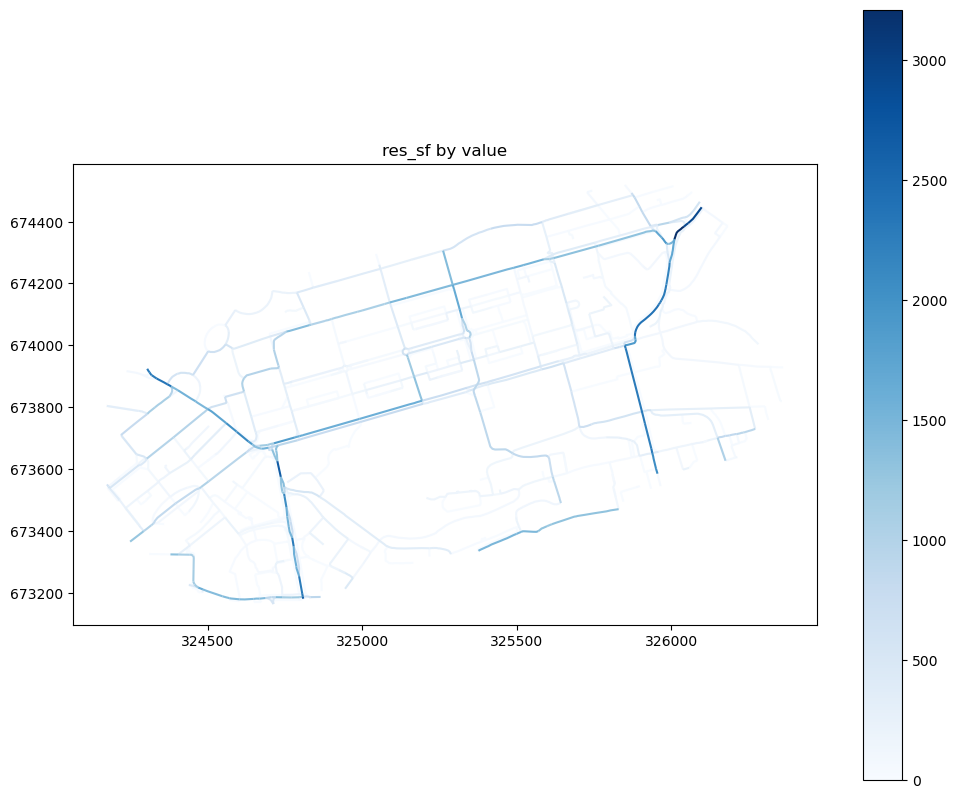

In [42]:
rnet_x_url = "https://github.com/ropensci/stplanr/releases/download/v1.0.2/rnet_x_ed.geojson"
rnet_y_url = "https://github.com/ropensci/stplanr/releases/download/v1.0.2/rnet_y_ed.geojson"

rnet_x = gpd.read_file(rnet_x_url)
rnet_x = rnet_x.to_crs(epsg=27700) 
rnet_y = gpd.read_file(rnet_y_url)
rnet_y = rnet_y.to_crs(epsg=27700) 

total_distance_traveled = round(sum(rnet_y['value'] * rnet_y['geometry'].length))
print(total_distance_traveled/1000)

fig, ax = plt.subplots(figsize=(12, 10))
rnet_y.plot(column='value', ax=ax, legend=True, cmap='Blues')
ax.set_title("res_sf by value")
plt.show()


In [43]:
print(rnet_x.shape)
rnet_x = rnet_subset(rnet_x, rnet_y, dist = 20,  min_length=5)
print(rnet_x.shape)

(474, 4)


c:\Users\wangz\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


(457, 4)


NameError: name 'rnet_x_min_length_0' is not defined

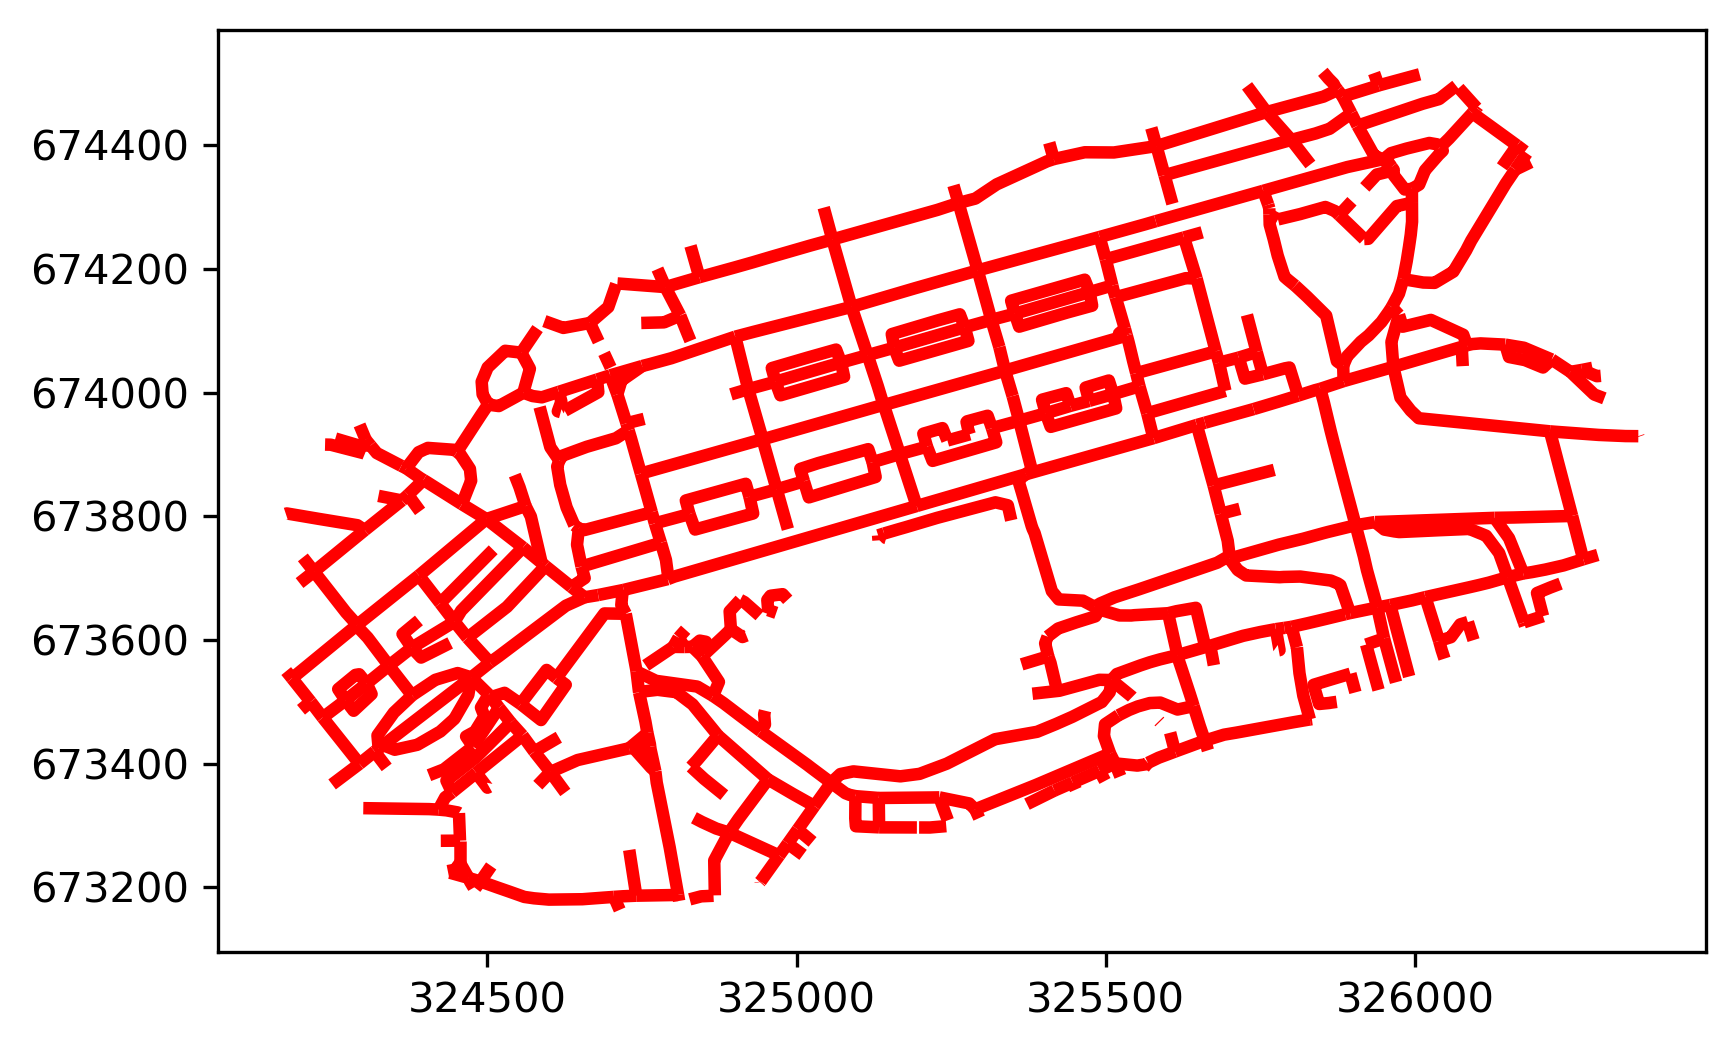

In [3]:

fig, ax = plt.subplots(1, 1,dpi=300)

rnet_x.plot(ax=ax, color='red',lw =3)   # plot gdf1
rnet_x_min_length_0.plot(ax=ax, color='blue',lw =1)  # plot gdf2

plt.show()

In [ ]:
funs = {'value': sum, 'Quietness': np.mean}

rnet_merged = rnet_merge(rnet_x, rnet_y, dist=20, segment_length=20, funs=funs)

In [44]:
rnet_x.crs = rnet_y.crs
funs = {'value': sum, 'Quietness': np.mean}
sum_cols = [name for name, func in funs.items() if func == sum]


In [45]:
rnetj = rnet_join(rnet_x, rnet_y, dist=20, dist_subset=20)
rnetj.shape

c:\Users\wangz\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
c:\Users\wangz\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\wangz\AppData\Local\Temp\ipykernel_9160\1571012287.py:146: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

  rnetj = gpd.sjoin(rnet_x_buffer_geo_df[[ 'geometry']], rnet_y_centroids, how='inner', op='intersects')


(2255, 6)

In [46]:
rnetj_df = rnetj.drop(columns=rnetj.geometry.name)

# Define aggregation function
def apply_funs(group):
    result = {}
    for col_name, fn in funs.items():
        matched_cols = group.filter(like=col_name)
        if fn == sum and sum_flows:
            result[col_name] = matched_cols.apply(lambda y: sum(y * group['length_y'])).sum()
        else:
            result[col_name] = matched_cols.apply(fn).sum()
    result['corr_line_geometry'] = group['corr_line_geometry'].iloc[0]
    return pd.Series(result)

In [47]:
sum_flows = True
res_df = rnetj_df.groupby(rnetj_df.columns[0]).apply(apply_funs).reset_index()

In [48]:
res_sf = rnet_x.join(res_df.set_index(rnetj_df.columns[0]), on=rnet_x.index)
res_sf.shape

(457, 7)

In [49]:
res_sf[res_sf.isnull().any(axis=1)]

,identifier,length_x_original,length_x_cropped,geometry,value,Quietness,corr_line_geometry
5,8E06C42A-AB3E-49E5-B60F-5E56273373B1,42.504501,70.424334,"LINESTRING (326281.980 674004.121, 326251.177 ...",NaN,NaN,NaN
7,5EF77F17-E3F7-4ED1-A307-4BF2D39F8C54,19.155208,19.096926,"LINESTRING (326251.177 674033.410, 326260.627 ...",NaN,NaN,NaN
15,8111E6C8-86C7-4626-8A8A-A70EAC28867A,27.911479,27.836547,"LINESTRING (326161.909 674360.330, 326187.032 ...",NaN,NaN,NaN
17,7E464AAF-DB8C-4D3B-A29E-AFD16F213214,365.349162,364.925224,"LINESTRING (325846.609 674005.940, 325847.659 ...",NaN,NaN,NaN
22,2BE6757C-A6E4-41C0-B766-CB31FDF70000,198.875604,198.292868,"LINESTRING (325884.478 674018.459, 325890.378 ...",NaN,NaN,NaN
...,...,...,...,...,...,...,...
425,65986B0E-F478-4E38-BB68-57DE0E8CD434,23.811905,82.471521,"LINESTRING (324677.505 674020.992, 324679.534 ...",NaN,NaN,NaN
431,C4D6D490-D9B1-4B97-8D9F-67F61FFA44CC,22.332435,22.267755,"LINESTRING (324677.505 674020.992, 324688.134 ...",NaN,NaN,NaN
439,F992915F-8E68-4B55-ADCC-36BA86F77ADF,22.929694,32.925118,"LINESTRING (324385.459 673815.971, 324383.244 ...",NaN,NaN,NaN
451,44CAABF2-7D35-41A3-8E80-E9BE03910C93,8.943992,8.919628,"LINESTRING (324368.944 673877.493, 324364.944 ...",NaN,NaN,NaN


In [24]:
if sum_flows:
    res_sf['length_x'] = res_sf.geometry.length
    length_y = rnet_y.geometry.length.sum()
    
    # Calculate the angle between 'corr_line_geometry' and 'geometry' for each row
    res_sf['angle'] = res_sf.apply(lambda row: calculate_angle(get_vector(gpd.GeoSeries(row['corr_line_geometry']).iloc[0]), 
                                                        get_vector(row['geometry'])), axis=1)
    
    for col_name in sum_cols:
        # Apply the adjustment only for rows where angle is less than 15 degrees
        mask = (res_sf['angle'] < 15) | (res_sf['angle'] > 160)
        res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / res_sf.loc[mask, 'length_x']
        
        over_estimate = (res_sf.loc[mask, col_name] * res_sf.loc[mask, 'length_x']).sum() / (rnet_y[col_name] * length_y).sum()
        res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / over_estimate

AttributeError: 'Series' object has no attribute 'geometry'

In [33]:
total_distance_traveled = round(sum(res_sf['value'] * res_sf['geometry'].length))
print(total_distance_traveled/1000)

18581243.85


In [ ]:
rnet_x.columns

In [ ]:
res_sf = rnet_x.join(res_df.set_index(rnetj_df.columns[0]), on=rnet_x.index)

In [ ]:
res_sf

In [ ]:
res_sf.columns

In [ ]:
res_sf['angle'] = res_sf.apply(lambda row: calculate_angle(get_vector(gpd.GeoSeries(row['corr_line_geometry']).iloc[0]), 
                                                        get_vector(row['geometry'])), axis=1)

In [ ]:
res_sf

In [ ]:

for col_name in sum_cols:
    # Apply the adjustment only for rows where angle is less than 15 degrees
    mask = (res_sf['angle'] < 15) | (res_sf['angle'] > 160)
    res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / res_sf.loc[mask, 'length_x']
    
    over_estimate = (res_sf.loc[mask, col_name] * res_sf.loc[mask, 'length_x']).sum() / (rnet_y[col_name] * length_y).sum()
    res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / over_estimate

In [ ]:
rnet_x.crs = rnet_y.crs
sum_cols = [name for name, func in funs.items() if func == sum]
rnetj = rnet_join(rnet_x, rnet_y, dist=20, dist_subset=20)

rnetj_df = rnetj.drop(columns=rnetj.geometry.name)

# Define aggregation function
def apply_funs(group):
    result = {}
    for col_name, fn in funs.items():
        matched_cols = group.filter(like=col_name)
        if fn == sum and sum_flows:
            result[col_name] = matched_cols.apply(lambda y: sum(y * group['length_y'])).sum()
        else:
            result[col_name] = matched_cols.apply(fn).sum()
    result['corr_line_geometry'] = group['corr_line_geometry'].iloc[0]
    return pd.Series(result)

res_df = rnetj_df.groupby(rnetj_df.columns[0]).apply(apply_funs).reset_index()
res_sf = rnet_x.join(res_df.set_index(rnetj_df.columns[0]), on=rnet_x.index)
# Convert NaN or invalid float values to None
res_sf.loc[res_sf['corr_line_geometry'].apply(type) == float, 'corr_line_geometry'] = None

# Convert the column to a GeoSeries
res_sf['corr_line_geometry'] = gpd.GeoSeries(res_sf['corr_line_geometry'])

if sum_flows:
    res_sf['length_x'] = res_sf.geometry.length
    length_y = rnet_y.geometry.length.sum()
    
    # Calculate the angle between 'corr_line_geometry' and 'geometry' for each row
    res_sf['angle'] = res_sf.apply(lambda row: calculate_angle(get_vector(gpd.GeoSeries(row['corr_line_geometry'])), 
                                                        get_vector(row['geometry'])), axis=1)

    
    for col_name in sum_cols:
        # Apply the adjustment only for rows where angle is less than 15 degrees
        mask = (res_sf['angle'] < 15) | (res_sf['angle'] > 160)
        res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / res_sf.loc[mask, 'length_x']
        
        over_estimate = (res_sf.loc[mask, col_name] * res_sf.loc[mask, 'length_x']).sum() / (rnet_y[col_name] * length_y).sum()
        res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / over_estimate

In [ ]:
total_distance_traveled = round(sum(res_sf['value'] * res_sf['geometry'].length))
print(total_distance_traveled/1000)

In [ ]:
rnet_x = rnet_subset(rnet_x, rnet_y, dist=20)
rnet_x.shape

In [ ]:
rnet_x_buffer = rnet_x.geometry.buffer(20, cap_style=3)
rnet_x_buffer_geo_df = gpd.GeoDataFrame(geometry=rnet_x_buffer, crs=rnet_x.crs)


In [ ]:
rnet_y['geometry'] = rnet_y['geometry'].apply(lambda geom: line_segment(geom, segment_length=segment_length))


In [ ]:
rnet_y_centroids = rnet_y.copy()
rnet_y_centroids['corr_line_geometry'] = rnet_y_centroids['geometry']
rnet_y_centroids['geometry'] = rnet_y.geometry.centroid


In [ ]:

fig, ax = plt.subplots(1, 1,dpi=300)

rnet_x_buffer_geo_df.plot(ax=ax, color='red') 
rnet_y_centroids.plot(ax=ax, color='blue' )
plt.show()

In [ ]:
rnetj = gpd.sjoin(rnet_x_buffer_geo_df[['geometry']], rnet_y_centroids, how='inner', op='intersects')
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffer regions (from rnet_x)
rnetj.plot(ax=ax, column='geometry', edgecolor='blue', facecolor='none')
plt.show()

In [ ]:
rnet_y_centroids.iloc[148]

In [ ]:
subset = rnetj[rnetj['index_right'] == 148]

# Generate a list of colors for each unique index in the subset
colors = plt.cm.jet(np.linspace(0, 1, len(subset)))

fig, ax = plt.subplots(figsize=(10, 10))

# Plot each geometry with its corresponding color
for idx, (color, (_, row)) in enumerate(zip(colors, subset.iterrows())):
    gpd.GeoSeries(row['geometry']).plot(ax=ax, color=color, label=f"Index {idx}")
gpd.GeoSeries(rnet_y_centroids.iloc[148]['geometry']).plot(ax=ax, color='blue', markersize=50)
plt.title("Geometries for index_right 148 with Different Colors")
plt.legend(loc="upper left")
plt.show()


In [ ]:
rnet_x.crs = rnet_y.crs
funs = {'value': sum, 'Quietness': np.mean}
sum_cols = [name for name, func in funs.items() if func == sum]
sum_cols

In [ ]:
rnetj = rnet_join(rnet_x, rnet_y, dist=20, dist_subset=10)
rnetj.shape

In [ ]:
rnetj_df = rnetj.drop(columns=rnetj.geometry.name)

In [ ]:
rnetj_df

In [ ]:
def apply_funs(group):
    result = {}
    for col_name, fn in funs.items():
        matched_cols = group.filter(like=col_name)
        if fn == sum and sum_flows:
            result[col_name] = matched_cols.apply(lambda y: sum(y * group['length_y'])).sum()
        else:
            result[col_name] = matched_cols.apply(fn).sum()
    return pd.Series(result)

res_df = rnetj_df.groupby(rnetj_df.columns[0]).apply(apply_funs).reset_index()


In [ ]:
res_sf = rnet_x.join(res_df.set_index(rnetj_df.columns[0]), on=rnet_x.index)

In [ ]:
res_sf

In [ ]:
res_sf['length_x'] = res_sf.geometry.length
length_y = rnet_y.geometry.length.sum()
for col_name in sum_cols:
    res_sf[col_name] = res_sf[col_name] / res_sf['length_x']
    over_estimate = (res_sf[col_name] * res_sf['length_x']).sum() / (rnet_y[col_name] * length_y).sum()
    res_sf[col_name] = res_sf[col_name] / over_estimate

In [ ]:
res_sf

In [ ]:
total_distance_traveled = round(sum(res_sf['value'] * res_sf['geometry'].length))
print(total_distance_traveled/1000)

In [ ]:
17159140/1000

In [ ]:
print("Original rnet_x:", len(rnet_x))
print("After rnet_subset:", len(rnet_x_min_length_0))


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
rnet_x.plot(ax=ax, color='blue', label='Original rnet_x')
rnet_x_min_length_0.plot(ax=ax, color='red', linestyle='--', label='After rnet_subset')
ax.set_title("Comparison between Original rnet_x and rnet_x_min_length_0")
ax.legend()
plt.show()


In [ ]:
avg_length_original = rnet_x['length_x_original'].mean()
avg_length_after_subset = rnet_x_min_length_0['length_x_original'].mean()

print("Average segment length in original rnet_x:", avg_length_original)
print("Average segment length in rnet_x_min_length_0:", avg_length_after_subset)


In [ ]:
rnet_y_centroids = rnet_y.copy()
rnet_y_centroids['geometry'] = rnet_y.geometry.centroid

In [ ]:
rnet_y_centroids

In [ ]:
rnet_x_buffer = rnet_x.geometry.buffer(20, cap_style=2)
rnet_x_buffer_geo_df = gpd.GeoDataFrame(geometry=rnet_x_buffer, crs=rnet_x.crs)


In [ ]:
rnetj = gpd.sjoin(rnet_x_buffer_geo_df[['geometry']], rnet_y_centroids, how='inner', op='intersects')


In [ ]:
# Set up the plotting figure and axis
fig, ax = plt.subplots(figsize=(12, 8), dpi=500)

# Plot the buffer of rnet_x
rnet_x_buffer.plot(ax=ax, color='blue', edgecolor='k', alpha=0.5, label='Buffer around rnet_x')

# Plot the original rnet_x for reference
rnet_x.plot(ax=ax, color='darkblue', label='Original rnet_x')

# Plot the centroids of rnet_y
rnet_y_centroids.plot(ax=ax, color='red', marker='o', markersize=50, label='Centroids of rnet_y')

# Plot the original rnet_y for reference
rnet_y.plot(ax=ax, color='darkred', linestyle='--', label='Original rnet_y')

# Set up legend and title
ax.legend(loc="upper left")
ax.set_title("Buffer around rnet_x and Centroids of rnet_y")

# Show the plot
plt.show()


In [ ]:
rnet_x.crs = rnet_y.crs

In [ ]:
# Define aggregation function
def apply_funs(group):
    result = {}
    for col_name, fn in funs.items():
        matched_cols = group.filter(like=col_name)
        if fn == sum and sum_flows:
            result[col_name] = matched_cols.apply(lambda y: sum(y * group['length_y'])).sum()
        else:
            result[col_name] = matched_cols.apply(fn).sum()
    return pd.Series(result)
sum_cols = [name for name, func in funs.items() if func == sum]
rnetj = rnet_join(rnet_x, rnet_y, dist=20, dist_subset=20)

In [ ]:
rnetj_df = rnetj.drop(columns=rnetj.geometry.name)

In [ ]:
    res_df = rnetj_df.groupby(rnetj_df.columns[0]).apply(apply_funs).reset_index()
    res_sf = rnet_x.join(res_df.set_index(rnetj_df.columns[0]), on=rnet_x.index)

In [ ]:

        res_sf['length_x'] = res_sf.geometry.length
        length_y = rnet_y.geometry.length.sum()
        for col_name in sum_cols:
            print(col_name)
            res_sf[col_name] = res_sf[col_name] / res_sf['length_x']
            over_estimate = (res_sf[col_name] * res_sf['length_x']).sum() / (rnet_y[col_name] * length_y).sum()
            res_sf[col_name] = res_sf[col_name] / over_estimate



In [ ]:
sum_cols

In [ ]:
funs = {'value': sum, 'Quietness': np.mean}

sum_cols = [name for name, func in funs.items() if func == sum]


In [ ]:
    def apply_funs(group):
        result = {}
        for col_name, fn in funs.items():
            matched_cols = group.filter(like=col_name)
            if fn == sum and sum_flows:
                result[col_name] = matched_cols.apply(lambda y: sum(y * group['length_y'])).sum()
            else:
                result[col_name] = matched_cols.apply(fn).sum()
        return pd.Series(result)

    res_df = rnetj_df.groupby(rnetj_df.columns[0]).apply(apply_funs).reset_index()
    res_sf = rnet_x.join(res_df.set_index(rnetj_df.columns[0]), on=rnet_x.index)


In [ ]:
    rnet_y_centroids = rnet_y.copy()
    rnet_y_centroids['corr_line_geometry'] = rnet_y_centroids['geometry']
    rnet_y_centroids['geometry'] = rnet_y.geometry.centroid
    
    # Perform spatial join
    rnetj = gpd.sjoin(rnet_x_buffer_geo_df[[ 'geometry']], rnet_y_centroids, how='inner', op='intersects')


In [ ]:
rnetj

In [ ]:
res_sf = rnet_x.join(res_df.set_index(rnetj_df.columns[0]), on=rnet_x.index)

In [ ]:
funs = None
if funs is None:
    funs = {}
    for col in rnet_y.columns:
        if pd.api.types.is_numeric_dtype(rnet_y[col]):
            funs[col] = sum

In [ ]:
rnet_x.crs = rnet_y.crs
funs = {'value': sum, 'Quietness': np.mean}
if funs is None:
    print('funs is none')
    funs = {}
    for col in rnet_y.columns:
        if pd.api.types.is_numeric_dtype(rnet_y[col]):
            funs[col] = sum

In [ ]:
sum_cols = [name for name, func in funs.items() if func == sum]
rnetj = rnet_join(rnet_x, rnet_y, dist=20, dist_subset=10)

In [ ]:
rnetj

In [ ]:
rnetj_df = rnetj.drop(columns=rnetj.geometry.name)
rnetj_df

In [ ]:
# Define aggregation function
def apply_funs(group):
    result = {}
    for col_name, fn in funs.items():
        matched_cols = group.filter(like=col_name)
        if fn == sum and sum_flows:
            result[col_name] = matched_cols.apply(lambda y: sum(y * group['length_y'])).sum()
        else:
            result[col_name] = matched_cols.apply(fn).sum()
    result['corr_line_geometry'] = group['corr_line_geometry'].iloc[0]
    return pd.Series(result)

res_df = rnetj_df.groupby(rnetj_df.columns[0]).apply(apply_funs).reset_index()
res_sf = rnet_x.join(res_df.set_index(rnetj_df.columns[0]), on=rnet_x.index)

In [ ]:
res_sf['corr_line_geometry']

In [ ]:
res_sf['geometry']

In [ ]:
import math
sum_flows = True
if sum_flows:
    res_sf['length_x'] = res_sf.geometry.length
    length_y = rnet_y.geometry.length.sum()
    
    # Calculate the angle between 'corr_line_geometry' and 'geometry' for each row
    res_sf['angle'] = res_sf.apply(lambda row: calculate_angle(get_vector(gpd.GeoSeries(row['corr_line_geometry']).iloc[0]), 
                                                           get_vector(row['geometry'])), axis=1)

    
    for col_name in sum_cols:
        # Apply the adjustment only for rows where angle is less than 15 degrees
        mask = res_sf['angle'] < 15
        res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / res_sf.loc[mask, 'length_x']
        
        over_estimate = (res_sf.loc[mask, col_name] * res_sf.loc[mask, 'length_x']).sum() / (rnet_y[col_name] * length_y).sum()
        res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / over_estimate



In [ ]:
import math

sum_flows = True
if sum_flows:
    res_sf['length_x'] = res_sf.geometry.length
    length_y = rnet_y.geometry.length.sum()
    
    # Calculate the angle between 'corr_line_geometry' and 'geometry' for each row
    def compute_angle(row):
        if pd.notnull(row['corr_line_geometry']) and isinstance(row['corr_line_geometry'], (LineString, MultiLineString)):
            return calculate_angle(get_vector(gpd.GeoSeries(row['corr_line_geometry']).iloc[0]), get_vector(row['geometry']))
        else:
            return None  # or return a default value like 0 or 180 if preferred
    
    res_sf['angle'] = res_sf.apply(compute_angle, axis=1)

    for col_name in sum_cols:
        # Apply the adjustment only for rows where angle is less than 15 degrees
        mask = res_sf['angle'] < 15
        res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / res_sf.loc[mask, 'length_x']
        
        over_estimate = (res_sf.loc[mask, col_name] * res_sf.loc[mask, 'length_x']).sum() / (rnet_y[col_name] * length_y).sum()
        res_sf.loc[mask, col_name] = res_sf.loc[mask, col_name] / over_estimate


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
res_sf.plot(column='value', ax=ax, legend=True, cmap='viridis')
ax.set_title("res_sf by value")
plt.show()

In [ ]:
res_sf['value'].unique()   
def calcuate_total_length():
    

In [ ]:
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the 'geometry' column in blue
res_sf.plot(ax=ax, column='geometry', color='blue', legend=True)

# Plot the 'corr_line_geometry' column in red
res_sf.set_geometry('corr_line_geometry').plot(ax=ax, color='red', legend=True)

# Set the legend and title
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10)
ax.legend([red_patch, blue_patch], ['corr_line_geometry', 'geometry'])
ax.set_title("Visualization of corr_line_geometry and geometry")

plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_selected_geometries(df, indices):
    # Filter the GeoDataFrame by the provided indices
    selected_df = df.loc[indices]

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the 'geometry' column in blue
    selected_df.plot(ax=ax, column='geometry', color='blue', legend=True)

    # Plot the 'corr_line_geometry' column in red
    selected_df.set_geometry('corr_line_geometry').plot(ax=ax, color='red', legend=True)

    # Set the legend and title
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10)
    ax.legend([red_patch, blue_patch], ['corr_line_geometry', 'geometry'])
    ax.set_title(f"Visualization of corr_line_geometry and geometry for indices: {indices}")

    plt.show()

# Example usage:
plot_selected_geometries(res_sf, [473])
